In [1]:
import datetime

import pandas as pd
import numpy as np
import seaborn as sbs

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 42
VERSION = '3.1'
GOOD_CNTR_CLR = '#5FFF92'
BAD_CNTR_CLR = '#FF665F'

pd.set_option('display.max_columns', 40)

In [3]:
# Считывание данных
data = pd.read_csv('../data/tula_yarobl_contracts.csv', converters={'okpd': str})

# Удаление строк с пропущенными значениями
data = data.dropna()

# Балансировка выборки
bad_cntr = data.loc[data.cntr_result == 0]
good_cntr = data.loc[data.cntr_result == 1].sample(bad_cntr.shape[0], random_state=RANDOM_SEED)
data = bad_cntr.append(good_cntr)

In [4]:
print('Размер выборки: {}'.format(data.shape))
data.head()

Размер выборки: (37546, 39)


,cntrID,ter_good_cntr_share,sup_cntr_num,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_1s_sev,sup_1s_org_sev,sup_okpd_exp,sup_sim_price_share,sup_status,sup_type,org_cntr_num,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_nun_cntr_share,org_cntr_avg_price,org_1s_sev,org_1s_sup_sev,org_sim_price_share,cntr_num_together,org_form,org_type,okpd_good_cntr_share,okpd,price,pmp,cntr_lvl,sign_date,exec_date,purch_type,price_higher_pmp,price_too_low,cntr_result
0,1505511,0.958,10,0.80,0.0,0.2,0.8,314948,0.0,1.0,0,0.0,1,0.1,-1,3,54,0.778,0.0,0.0,1.0,451433,0,0.0,0.33333,1,45,1,0.946831,0,634088.54,899416.26,3,20150112,20150630,3,0,0,0
1,1505700,0.958,1,0.00,0.0,1.0,0.0,20962,0.0,1.0,0,0.0,1,1.0,-1,0,572,0.944,0.0,1.0,0.0,177977,0,0.0,0.04720,1,45,1,0.946831,0,20962.00,22000.00,2,20150112,20150630,4,0,0,0
2,1506010,0.958,5,0.60,0.0,1.0,0.0,112320,0.0,1.0,0,0.0,0,0.2,-1,2,569,0.875,0.0,1.0,0.0,443843,0,0.0,0.09666,2,8,3,0.946831,0,102600.00,114000.00,2,20150101,20160331,4,0,0,0
3,1506012,0.958,5,0.60,0.0,1.0,0.0,112320,0.0,1.0,0,0.0,0,0.2,-1,2,569,0.875,0.0,1.0,0.0,443843,0,0.0,0.11951,2,8,3,0.946831,0,438000.00,500000.00,2,20150112,20160331,4,0,0,0
4,1506028,0.958,4,0.75,0.0,1.0,0.0,123842,0.0,1.0,0,0.0,1,0.5,-1,3,309,0.874,0.0,1.0,0.0,241646,0,0.0,0.09061,1,66,1,0.946831,0,107000.00,158511.70,2,20150112,20151231,3,0,0,0


In [5]:
# Перемена местами обозначений целевой переменной: "0" соответствует хорошему контракту, "1" - плохому 
data.loc[data.cntr_result == 0, 'cntr_result'] = 2
data.loc[data.cntr_result == 1, 'cntr_result'] = 0
data.loc[data.cntr_result == 2, 'cntr_result'] = 1

In [6]:
def export_dataset(df):
    """Функция экспорта выборки для публикации датасета"""
    
    # Замена неуказанных значений категориальных переменных самыми часто встречающимися
    df.loc[(data.cntr_lvl == -1) | (df.cntr_lvl == 0), 'cntr_lvl'] = df.cntr_lvl.value_counts().index[0]
    df.loc[(data.org_type == -1) | (df.org_type == 0), 'org_type'] = df.org_type.value_counts().index[0]
    df.loc[(data.org_form == -1) | (df.org_form == 0), 'org_form'] = df.org_form.value_counts().index[0]
    df.loc[(data.purch_type == -1) | (df.purch_type == 0), 'purch_type'] = df.purch_type.value_counts().index[0]
    
    # Удаление ID контракта
    df.drop(['cntrID'], inplace=True, axis=1)
    
    # Запись выборки в CSV файл
    df.to_csv(path_or_buf='../data/dataset_v{}.csv'.format(VERSION), encoding='utf-8')

In [7]:
export_dataset(data.copy())

In [8]:
# Удаление неинформативных переменных (доля хороших контрактов по территории и ID контракта)
data.drop(['ter_good_cntr_share', 'cntrID'], inplace=True, axis=1)
# Удаление данных с пропущенной датой окончания контракта
data.drop(data[data.exec_date == -1].index, inplace=True)

In [9]:
# Список количественных переменных с нефиксированной областью значений
num_var = [
        'sup_cntr_num', 'sup_cntr_avg_price', 'org_cntr_num', 'org_cntr_avg_price', 
        'price', 'pmp', 'cntr_num_together'
    ]

# Список количественных переменных с областью значений от 0 до 1
num_var01 = [
        'sup_good_cntr_share', 'sup_fed_cntr_share', 'sup_sub_cntr_share', 
        'sup_nun_cntr_share', 'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 'sup_okpd_exp', 
        'sup_no_pnl_share', 'sup_sim_price_share', 'org_good_cntr_share', 'org_fed_cntr_share', 
        'org_sub_cntr_share', 'org_nun_cntr_share', 'org_1s_sev', 'org_1s_sup_sev', 'org_sim_price_share', 
        'okpd_good_cntr_share'
    ]

# Список категориальных переменных
cat_var = ['sup_status', 'sup_type', 'org_form', 'org_type', 'okpd', 'cntr_lvl', 'purch_type']

# Список бинарных переменных
cat_bin_var = ['price_higher_pmp', 'price_too_low']

In [10]:
# Создание дополнительных переменных, использующих первые 2, 3 и 4 символа ОКПД
data['okpd_2'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))
data['okpd_3'] = data['okpd'].apply(lambda a: pd.Series(a[:3]))
data['okpd_4'] = data['okpd'].apply(lambda a: pd.Series(a[:4]))

In [11]:
# Добавление переменной, отражающей квартал заключения контракта
sign_month = data['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))
data['quarter'] = sign_month.apply(lambda a: pd.Series((a - 1) // 3 + 1))

In [12]:
# Рассчет длительности контракта
cntr_start = data['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
cntr_end = data['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
data['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))

In [13]:
# Удаление переменной ОКПД
cat_var.remove('okpd')

# Добавление новых переменных
cat_var.append('okpd_2')
cat_var.append('okpd_3')
cat_var.append('okpd_4')
cat_var.append('quarter')
num_var.append('cntr_length')

# Анализ данных
## Анализ количественных переменных
### Анализ количественных переменных с нефиксированной областью значений

In [14]:
# Описательные статистики
data[num_var].describe()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together,cntr_length
count,37544.000000,3.754400e+04,37544.000000,3.754400e+04,3.754400e+04,3.754400e+04,37544.000000,37544.000000
mean,2392.623082,5.360012e+05,515.253995,6.136351e+05,6.860431e+05,7.441954e+05,24.239319,158.028713
std,3238.826456,8.878901e+06,704.569882,2.114312e+06,8.956323e+06,9.318822e+06,35.117926,106.676383
min,1.000000,0.000000e+00,1.000000,2.673000e+03,1.000000e-02,0.000000e+00,1.000000,0.000000
25%,18.000000,8.772700e+04,116.000000,1.489080e+05,3.910334e+04,4.280376e+04,2.000000,94.000000
50%,251.000000,1.447320e+05,238.000000,2.459070e+05,1.049055e+05,1.182614e+05,9.000000,149.000000
75%,6921.000000,2.344480e+05,653.000000,4.096678e+05,3.385122e+05,3.898000e+05,40.000000,184.000000
max,7651.000000,1.151663e+09,6408.000000,6.803218e+07,1.151663e+09,1.205930e+09,509.000000,2922.000000


In [15]:
# Мода, медиана, среднее
result = {'mode': [], 'median': [], 'mean': []}
for nv in num_var:
    result['mode'].append(int(data[nv].mode()[0]))
    result['median'].append(int(data[nv].median()))
    result['mean'].append(int(data[nv].mean()))

result = pd.DataFrame(result, index=num_var)
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
sup_cntr_num,7651,251,2392
sup_cntr_avg_price,144732,144732,536001
org_cntr_num,260,238,515
org_cntr_avg_price,284701,245907,613635
price,4594368,104905,686043
pmp,0,118261,744195
cntr_num_together,1,9,24
cntr_length,152,149,158


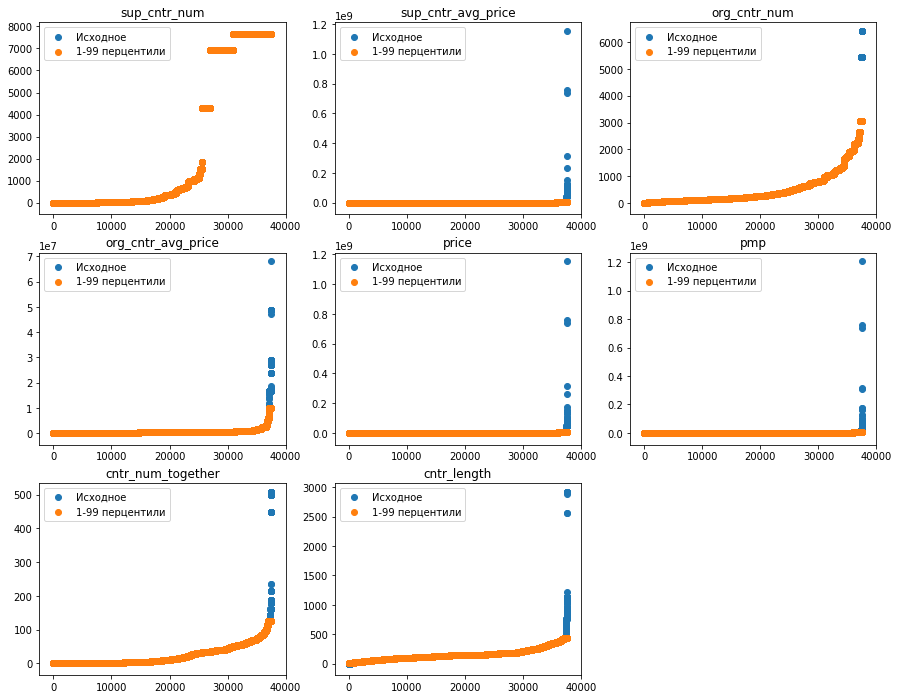

In [16]:
# Исходные значения переменных и значения в границах [1, 99] перцентилей
fig = plt.figure(figsize=(15, 12))
for idx, nv in enumerate(num_var):
    ax = fig.add_subplot(330 + idx + 1)
    
    df = data.copy()
    ulimit = np.percentile(df[nv].values, 99)
    dlimit = np.percentile(df[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    ax.scatter(range(data.shape[0]), np.sort(data[nv]), label='Исходное')
    ax.scatter(range(df.shape[0]), np.sort(df[nv]), label='1-99 перцентили')
    ax.legend()
    ax.set_title(nv)

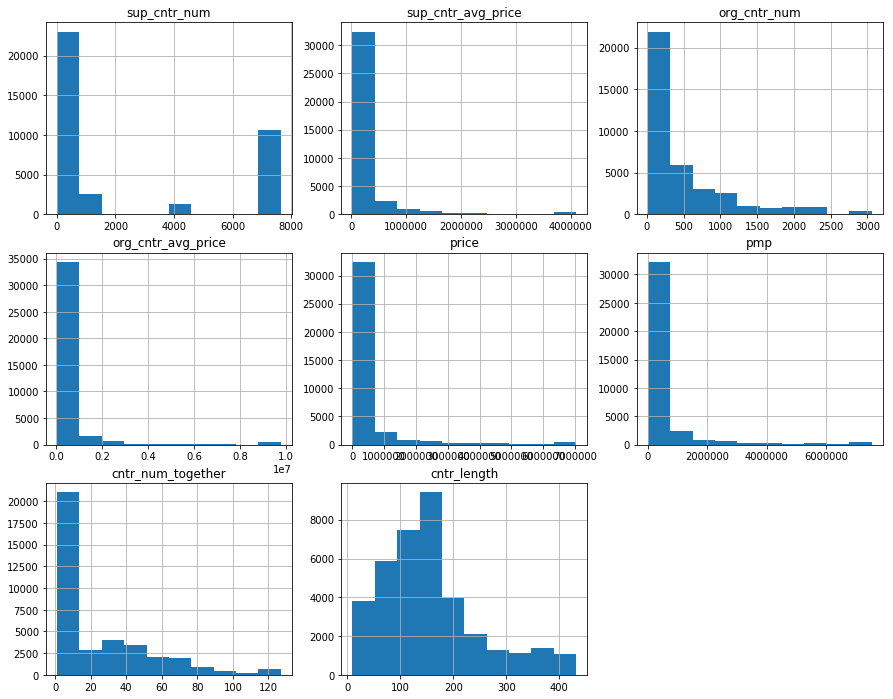

In [17]:
# Гистограммы переменных в границах [1, 99] перцентилей
fig = plt.figure(figsize=(15, 12))
for idx, nv in enumerate(num_var):
    ax = fig.add_subplot(330 + idx + 1)
    df = data.copy()
    
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    df[nv].hist(ax=ax)
    ax.set_title(nv)

In [18]:
# Корреляционная матрица
data[num_var + ['cntr_result']].corr()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together,cntr_length,cntr_result
sup_cntr_num,1.000000,-0.032985,-0.254238,-0.121680,-0.013031,-0.014185,0.523296,-0.045082,0.350202
sup_cntr_avg_price,-0.032985,1.000000,0.013607,0.167620,0.962452,0.958254,-0.020996,0.121871,0.003918
org_cntr_num,-0.254238,0.013607,1.000000,0.060273,0.011625,0.012141,0.023348,0.148073,-0.255362
org_cntr_avg_price,-0.121680,0.167620,0.060273,1.000000,0.193840,0.205929,-0.054478,0.073041,-0.058637
price,-0.013031,0.962452,0.011625,0.193840,1.000000,0.997599,-0.014515,0.134551,0.012845
pmp,-0.014185,0.958254,0.012141,0.205929,0.997599,1.000000,-0.016235,0.143028,0.013181
cntr_num_together,0.523296,-0.020996,0.023348,-0.054478,-0.014515,-0.016235,1.000000,-0.017593,0.127830
cntr_length,-0.045082,0.121871,0.148073,0.073041,0.134551,0.143028,-0.017593,1.000000,0.083411
cntr_result,0.350202,0.003918,-0.255362,-0.058637,0.012845,0.013181,0.127830,0.083411,1.000000


In [19]:
def rate_feature_importance(X_values, y_values, criteria, columns, alias=''):
    """Функция для оценки важности признаков по критерию"""
    
    result_dict = {}
    result_list = []
    
    for criterium in criteria:
        test = SelectKBest(score_func=criterium, k='all')
        fit = test.fit(X_values, y_values)
        res = sorted(
            dict(zip(columns, [e for e in list(fit.scores_)])).items(),
            key=lambda a: a[1],
            reverse=True
        )
        
        func_name = str(criterium).split()[1]
        dict_key = '{}_{}'.format(alias, func_name) if alias else func_name
        
        result_dict[dict_key] = [i[0] for i in res]
        result_list.append(res)
    
    return pd.DataFrame(result_dict), result_list

In [20]:
# ANOVA тест
res_df, res_list = rate_feature_importance(data[num_var].values, data.cntr_result.values, [f_classif], num_var)
res_df['f_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'f_score']
res_df

,var_name,f_score
0,sup_cntr_num,5247
1,org_cntr_num,2618
2,cntr_num_together,623
3,cntr_length,263
4,org_cntr_avg_price,129
5,pmp,6
6,price,6
7,sup_cntr_avg_price,0


### Анализ количественных переменных с фиксированной областью значений [0, 1]

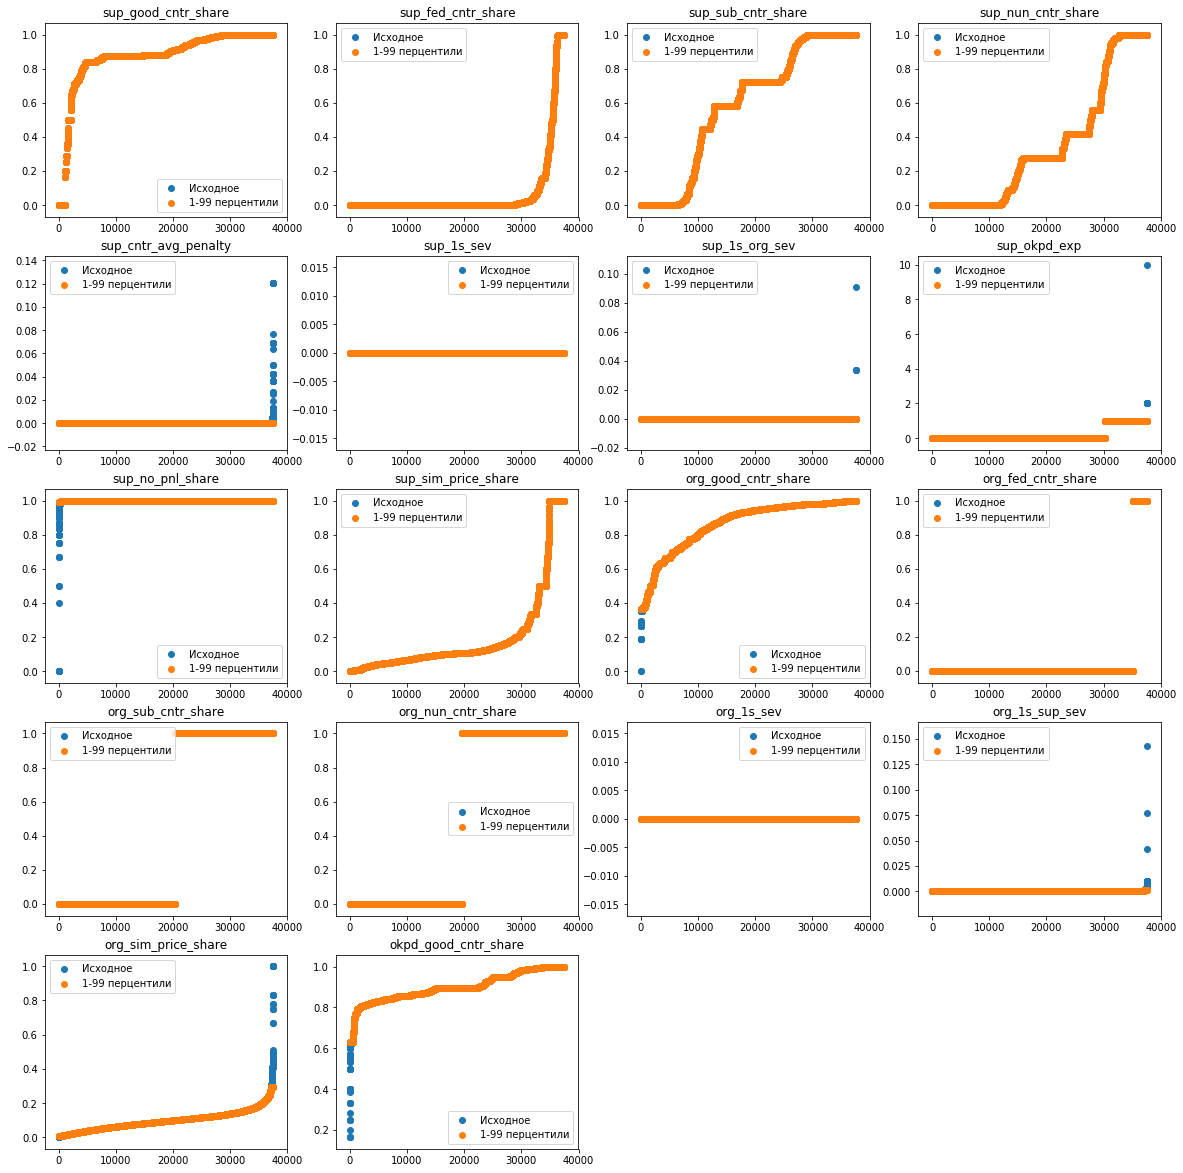

In [21]:
# Исходные значения переменных и значения в границах [1, 99] перцентилей
fig = plt.figure(figsize=(20, 25))
for idx, nv in enumerate(num_var01):
    ax = fig.add_subplot(6, 4, idx + 1)
    df = data.copy()
    
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    ax.scatter(range(data.shape[0]), np.sort(data[nv]), label='Исходное')
    ax.scatter(range(df.shape[0]), np.sort(df[nv]), label='1-99 перцентили')
    ax.legend()
    ax.set_title(nv)

In [22]:
# Описательные статистики
data[num_var01].describe()

,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_penalty,sup_1s_sev,sup_1s_org_sev,sup_okpd_exp,sup_no_pnl_share,sup_sim_price_share,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_nun_cntr_share,org_1s_sev,org_1s_sup_sev,org_sim_price_share,okpd_good_cntr_share
count,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.0,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.0,37544.000000,37544.000000,37544.000000
mean,0.873959,0.069177,0.583237,0.347367,0.000142,0.0,0.000005,0.193400,0.999477,0.196439,0.863390,0.064644,0.456424,0.478878,0.0,0.000036,0.100250,0.899628
std,0.192598,0.215143,0.371353,0.357991,0.002860,0.0,0.000556,0.398393,0.014599,0.255224,0.155322,0.245900,0.498104,0.499560,0.0,0.000930,0.062499,0.073394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.166667
25%,0.875000,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.063883,0.781750,0.000000,0.000000,0.000000,0.0,0.000000,0.059780,0.855932
50%,0.884000,0.000000,0.721000,0.278000,0.000000,0.0,0.000000,0.000000,1.000000,0.105640,0.935000,0.000000,0.000000,0.000000,0.0,0.000000,0.095040,0.894846
75%,0.991000,0.001000,0.976000,0.556000,0.000000,0.0,0.000000,0.000000,1.000000,0.178632,0.976000,0.000000,1.000000,1.000000,0.0,0.000000,0.128290,0.954686
max,1.000000,1.000000,1.000000,1.000000,0.120910,0.0,0.090910,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.142860,1.000000,1.000000


In [23]:
# Переменные, являющиеся константами
num_var01_useless = [
    'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 
    'sup_no_pnl_share', 'org_1s_sev', 'org_1s_sup_sev'
]

In [24]:
# Мода, медиана, среднее
result = {'mode': [], 'median': [], 'mean': []}
for nv01 in list(set(num_var01) - set(num_var01_useless)):
    result['mode'].append(data[nv01].mode()[0])
    result['median'].append(data[nv01].median())
    result['mean'].append(data[nv01].mean())

result = pd.DataFrame(result, index=list(set(num_var01) - set(num_var01_useless)))
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
org_good_cntr_share,1.000000,0.935000,0.863390
sup_good_cntr_share,1.000000,0.884000,0.873959
sup_okpd_exp,0.000000,0.000000,0.193400
sup_fed_cntr_share,0.000000,0.000000,0.069177
org_sub_cntr_share,0.000000,0.000000,0.456424
sup_sim_price_share,1.000000,0.105640,0.196439
sup_sub_cntr_share,1.000000,0.721000,0.583237
sup_nun_cntr_share,0.000000,0.278000,0.347367
org_sim_price_share,0.125000,0.095040,0.100250
okpd_good_cntr_share,0.894846,0.894846,0.899628


In [25]:
# Описателные характеристики
data[list(set(num_var01) - set(num_var01_useless))].describe()

,org_good_cntr_share,sup_good_cntr_share,sup_okpd_exp,sup_fed_cntr_share,org_sub_cntr_share,sup_sim_price_share,sup_sub_cntr_share,sup_nun_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_nun_cntr_share,org_fed_cntr_share
count,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000
mean,0.863390,0.873959,0.193400,0.069177,0.456424,0.196439,0.583237,0.347367,0.100250,0.899628,0.478878,0.064644
std,0.155322,0.192598,0.398393,0.215143,0.498104,0.255224,0.371353,0.357991,0.062499,0.073394,0.499560,0.245900
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
25%,0.781750,0.875000,0.000000,0.000000,0.000000,0.063883,0.200000,0.000000,0.059780,0.855932,0.000000,0.000000
50%,0.935000,0.884000,0.000000,0.000000,0.000000,0.105640,0.721000,0.278000,0.095040,0.894846,0.000000,0.000000
75%,0.976000,0.991000,0.000000,0.001000,1.000000,0.178632,0.976000,0.556000,0.128290,0.954686,1.000000,0.000000
max,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


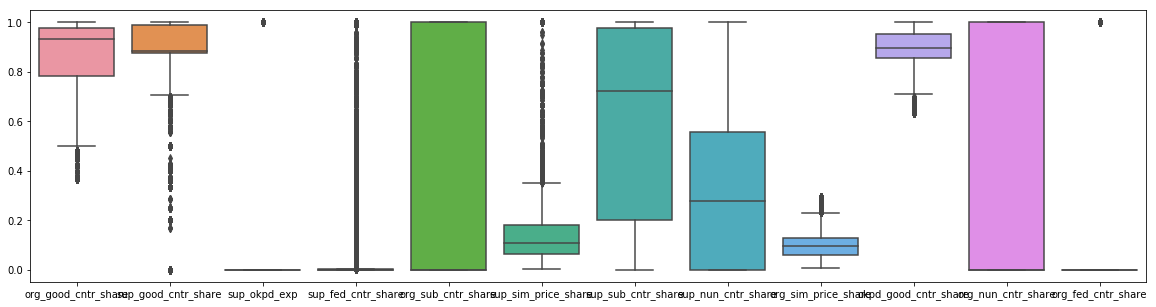

In [26]:
# Описательные характеритстики в форме ящика с усами
df = data.copy()
for nv01 in list(set(num_var01) - set(num_var01_useless)):
    ulimit = np.percentile(data[nv01].values, 99)
    dlimit = np.percentile(data[nv01].values, 1)
    df.loc[df[nv01] > ulimit, nv01] = ulimit
    df.loc[df[nv01] < dlimit, nv01] = dlimit

ax = plt.figure(figsize=(20, 5)).gca()
sbs.boxplot(data=df[list(set(num_var01) - set(num_var01_useless))], ax=ax)

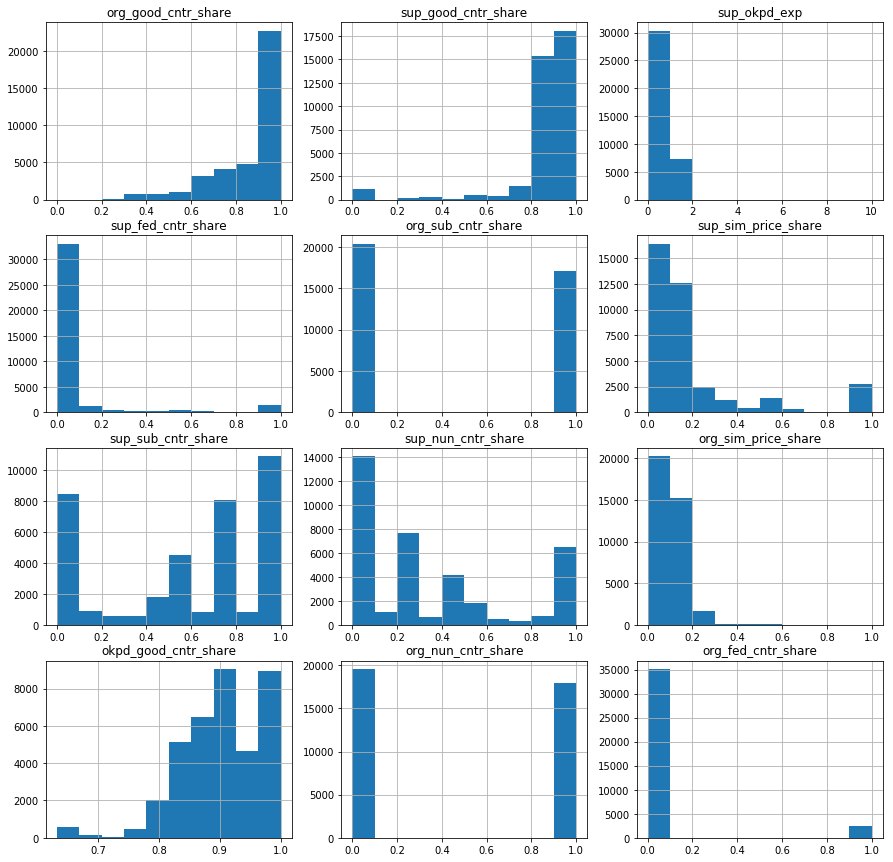

In [27]:
# Гистограммы переменных в границах [1, 99] перцентилей
fig = plt.figure(figsize=(15, 15))
for idx, nv01 in enumerate(list(set(num_var01) - set(num_var01_useless))):
    ax = fig.add_subplot(4, 3, idx + 1)
    df = data.copy()
    
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    df[nv01].hist(ax=ax)
    ax.set_title(nv01)

In [28]:
# Корреляционная матрица
data[list(set(num_var01) - set(num_var01_useless)) + ['cntr_result']].corr()

,org_good_cntr_share,sup_good_cntr_share,sup_okpd_exp,sup_fed_cntr_share,org_sub_cntr_share,sup_sim_price_share,sup_sub_cntr_share,sup_nun_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_nun_cntr_share,org_fed_cntr_share,cntr_result
org_good_cntr_share,1.000000,0.075942,0.118452,0.193303,0.511128,0.251545,0.142728,-0.264443,-0.032817,0.389951,-0.594357,0.172619,-0.534401
sup_good_cntr_share,0.075942,1.000000,-0.266542,0.013623,0.132085,-0.314947,0.170857,-0.185339,-0.013675,0.220852,-0.138399,0.013606,-0.424108
sup_okpd_exp,0.118452,-0.266542,1.000000,0.142231,0.017168,0.567165,-0.084925,0.002879,-0.017606,0.125950,-0.081390,0.130406,-0.094712
sup_fed_cntr_share,0.193303,0.013623,0.142231,1.000000,-0.175353,0.274864,-0.351223,-0.236912,-0.015663,0.169398,-0.246107,0.854757,-0.149892
org_sub_cntr_share,0.511128,0.132085,0.017168,-0.175353,1.000000,0.070553,0.694578,-0.615383,-0.106732,0.353245,-0.878410,-0.240897,-0.367106
sup_sim_price_share,0.251545,-0.314947,0.567165,0.274864,0.070553,1.000000,-0.094677,-0.066844,0.064350,0.233829,-0.187829,0.238670,-0.153690
sup_sub_cntr_share,0.142728,0.170857,-0.084925,-0.351223,0.694578,-0.094677,1.000000,-0.826341,-0.226092,0.189906,-0.546391,-0.296690,-0.146978
sup_nun_cntr_share,-0.264443,-0.185339,0.002879,-0.236912,-0.615383,-0.066844,-0.826341,1.000000,0.243790,-0.299166,0.715142,-0.206233,0.242578
org_sim_price_share,-0.032817,-0.013675,-0.017606,-0.015663,-0.106732,0.064350,-0.226092,0.243790,1.000000,-0.024128,0.116645,-0.022736,0.027367
okpd_good_cntr_share,0.389951,0.220852,0.125950,0.169398,0.353245,0.233829,0.189906,-0.299166,-0.024128,1.000000,-0.424156,0.145861,-0.467908


In [29]:
# Корреляции объясняющих переменных с целевой
data[list(set(num_var01) - set(num_var01_useless))].corrwith(data.cntr_result)

org_good_cntr_share    -0.534401
sup_good_cntr_share    -0.424108
sup_okpd_exp           -0.094712
sup_fed_cntr_share     -0.149892
org_sub_cntr_share     -0.367106
sup_sim_price_share    -0.153690
sup_sub_cntr_share     -0.146978
sup_nun_cntr_share      0.242578
org_sim_price_share     0.027367
okpd_good_cntr_share   -0.467908
org_nun_cntr_share      0.435503
org_fed_cntr_share     -0.141126
dtype: float64

In [30]:
# ANOVA тест
res_df, res_list = rate_feature_importance(
    data[list(set(num_var01) - set(num_var01_useless))].values, 
    data.cntr_result.values, [f_classif], num_var01
)
res_df['f_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'f_score']
res_df

,var_name,f_score
0,sup_good_cntr_share,15007
1,sup_sim_price_share,10523
2,org_good_cntr_share,8786
3,sup_fed_cntr_share,8233
4,sup_cntr_avg_penalty,5847
5,sup_okpd_exp,2347
6,sup_1s_sev,908
7,sup_nun_cntr_share,862
8,sup_1s_org_sev,828
9,org_fed_cntr_share,762


## Анализ номинальных переменных
### Анализ небинарных переменных

In [31]:
# Количество уникальных значений
list(zip(cat_var, [len(set(data[cv].values)) for cv in cat_var]))

[('sup_status', 7),
 ('sup_type', 4),
 ('org_form', 71),
 ('org_type', 17),
 ('cntr_lvl', 4),
 ('purch_type', 7),
 ('okpd_2', 75),
 ('okpd_3', 192),
 ('okpd_4', 349),
 ('quarter', 4)]

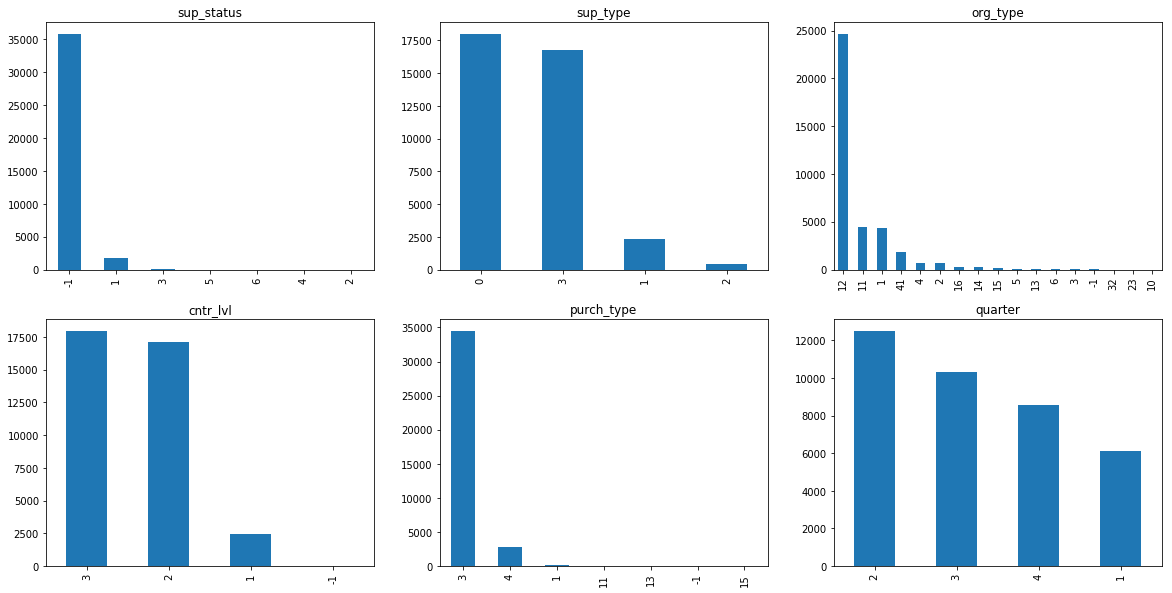

In [32]:
# Частотная гистограмма
fig = plt.figure(figsize=(20, 10))
idx = 1
for cv in cat_var:
    if cv not in ('okpd_2', 'okpd_3', 'okpd_4', 'org_form'):
        ax = fig.add_subplot(2, 3, idx)
        data[cv].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(cv)
        idx += 1

In [33]:
for cv in cat_var:
    data.loc[data[cv]==-1, cv] = 0

# Хи-квадрат тест
res_df, res_list = rate_feature_importance(data[cat_var].values, data.cntr_result.values, [chi2], cat_var)
res_df['chi2_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'chi2_score']
res_df

,var_name,chi2_score
0,okpd_4,1896693
1,okpd_3,190259
2,okpd_2,20075
3,org_form,1975
4,cntr_lvl,989
5,org_type,718
6,quarter,37
7,sup_status,33
8,sup_type,33
9,purch_type,5


In [34]:
# Группировка редко встречающихся значений
df = data.copy()
for cv in cat_var:
    cnt = data[cv].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        if count / data.shape[0] <= 0.005:
            df.loc[df[cv] == val, cv] = 'NEW'

good_num = df.loc[data.cntr_result == 1].shape[0]
bad_num = df.loc[data.cntr_result == 1].shape[0]
res = {}

# Вычисление Information Value
for cv in cat_var:
    res[cv] = []
    for val in set(df[cv].values):
        good_with_val = df.loc[(data.cntr_result == 1) & (df[cv] == val)].shape[0]
        bad_with_val = df.loc[(data.cntr_result == 0) & (df[cv] == val)].shape[0]
        p = good_with_val / good_num
        q = bad_with_val / bad_num
        w = np.log(p / q)
        res[cv].append((p - q) * w)

for key, value in res.items():
    print('{}: {:.3f}'.format(key, sum(res[key])))

sup_status: 0.004
sup_type: 0.006
org_form: 0.053
org_type: 0.072
cntr_lvl: 0.820
purch_type: 0.034
okpd_2: 1.207
okpd_3: 1.183
okpd_4: 1.134
quarter: 0.014


### Анализ бинарных переменных

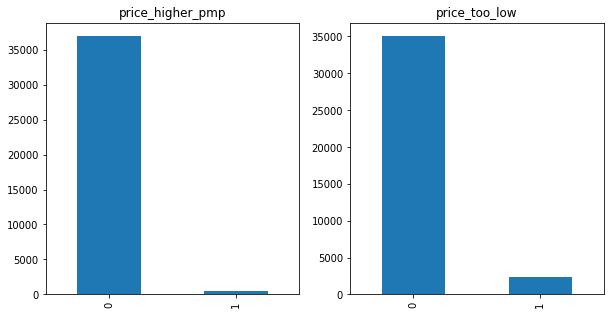

In [35]:
# Частотная гистограмма
fig = plt.figure(figsize=(10, 5))
for idx, cb in enumerate(cat_bin_var):
    ax = fig.add_subplot(1, 2, idx + 1)
    data[cb].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(cb)

In [36]:
print('Доля значений "1" для price_higher_pmp: {:.4f}'.format(
    data.price_higher_pmp.value_counts().values[1] / data.shape[0]))
print('Доля значений "1" для price_too_low: {:.4f}'.format(
    data.price_too_low.value_counts().values[1] / data.shape[0]))

Доля значений "1" для price_higher_pmp: 0.0142
Доля значений "1" для price_too_low: 0.0645


In [37]:
# Хи-квадрат тест
res_df, res_list = rate_feature_importance(data[cat_bin_var].values, data.cntr_result.values, [chi2], cat_bin_var)
res_df['chi2_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'chi2_score']
res_df

,var_name,chi2_score
0,price_too_low,404
1,price_higher_pmp,63


In [38]:
good_num = data.loc[data.cntr_result == 1].shape[0]
bad_num = data.loc[data.cntr_result == 1].shape[0]
res = {}

# Расчет Information Value
for cv in cat_bin_var:
    res[cv] = []
    for val in set(data[cv].values):
        good_with_val = data.loc[(data.cntr_result == 1) & (data[cv] == val)].shape[0]
        bad_with_val = data.loc[(data.cntr_result == 0) & (data[cv] == val)].shape[0]
        p = good_with_val / good_num
        q = bad_with_val / bad_num
        w = np.log(p / q)
        res[cv].append((p - q) * w)

for key, value in res.items():
    print('{}: {:.3f}'.format(key, sum(res[key])))

price_higher_pmp: 0.007
price_too_low: 0.049


# Предобработка

## Количественные переменные с нефиксированной облатью значений

In [39]:
# Удаление переменных
num_var.remove('price')
num_var.remove('pmp')
num_var.remove('cntr_num_together')

In [40]:
# Обработка выбросов
for nv in data[num_var]:
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    data.loc[data[nv] > ulimit, nv] = ulimit
    data.loc[data[nv] < dlimit, nv] = dlimit

# Дополнительная обработка выбросов
for idx, nv in enumerate(('sup_cntr_avg_price', 'org_cntr_avg_price', 'cntr_length')):
    if idx != 2:
        ulimit = np.percentile(data[nv].values, 95)
        data.loc[data[nv] > ulimit, nv] = ulimit  
    else:   
        dlimit = np.percentile(data[nv].values, 5)
        data.loc[data[nv] < dlimit, nv] = dlimit

In [41]:
# Логарифмирование
for nv in data[num_var]:
    data.loc[data[nv] < 1, nv] = 1
    data[nv] = np.log(data[nv])

In [42]:
# Нормализация
scaler = StandardScaler()
data[num_var] = scaler.fit_transform(data[num_var])

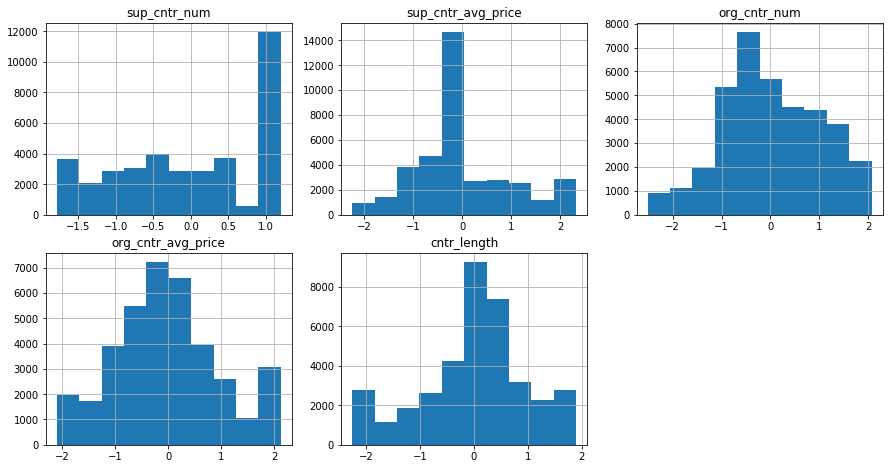

In [43]:
# Гистограммы
fig = plt.figure(figsize=(15, 12))
for idx, nv in enumerate(num_var):
    ax = fig.add_subplot(330 + idx + 1)
    
    data[nv].hist(ax=ax)
    ax.set_title(nv)

In [44]:
# Матрица корреляции
data[num_var + ['cntr_result']].corr()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,cntr_length,cntr_result
sup_cntr_num,1.000000,-0.218541,-0.229873,-0.326736,0.159318,0.308596
sup_cntr_avg_price,-0.218541,1.000000,0.319875,0.489085,0.068765,-0.135901
org_cntr_num,-0.229873,0.319875,1.000000,0.277529,0.091328,-0.310640
org_cntr_avg_price,-0.326736,0.489085,0.277529,1.000000,-0.035068,-0.121982
cntr_length,0.159318,0.068765,0.091328,-0.035068,1.000000,0.180458
cntr_result,0.308596,-0.135901,-0.310640,-0.121982,0.180458,1.000000


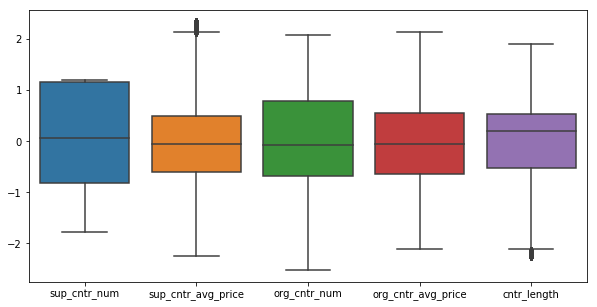

In [45]:
# Описательные статистики в виде ящика с усами
ax = plt.figure(figsize=(10, 5)).gca()
sbs.boxplot(data=data[num_var], ax=ax)

### Предобработка количественных переменных с область определения [0, 1]

In [46]:
# Удаление переменных
useless_num_var01 = [
    'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 
    'sup_no_pnl_share', 'org_1s_sev', 'org_1s_sup_sev', 'sup_okpd_exp',
    'org_sim_price_share'
]
for var in useless_num_var01:
    num_var01.remove(var)

In [47]:
# Обработка выбросов
for nv01 in num_var01:
    ulimit = np.percentile(data[nv01].values, 99)
    dlimit = np.percentile(data[nv01].values, 1)
    data.loc[data[nv01] > ulimit, nv01] = ulimit
    data.loc[data[nv01] < dlimit, nv01] = dlimit

## Предобработка номинальных переменных
### Предобработка номинальных небинарных переменных

In [48]:
# Удаление переменных
cat_var.remove('sup_status')
cat_var.remove('sup_type')

In [49]:
# Замена пропущенных значений наиболее часто встречающимися
data.loc[(data.cntr_lvl == -1) | (data.cntr_lvl == 0), 'cntr_lvl'] = data.cntr_lvl.value_counts().index[0]
data.loc[(data.org_type == -1) | (data.org_type == 0), 'org_type'] = data.org_type.value_counts().index[0]
data.loc[(data.org_form == -1) | (data.org_form == 0), 'org_form'] = data.org_form.value_counts().index[0]
data.loc[(data.purch_type == -1) | (data.purch_type == 0), 'purch_type'] = data.purch_type.value_counts().index[0]

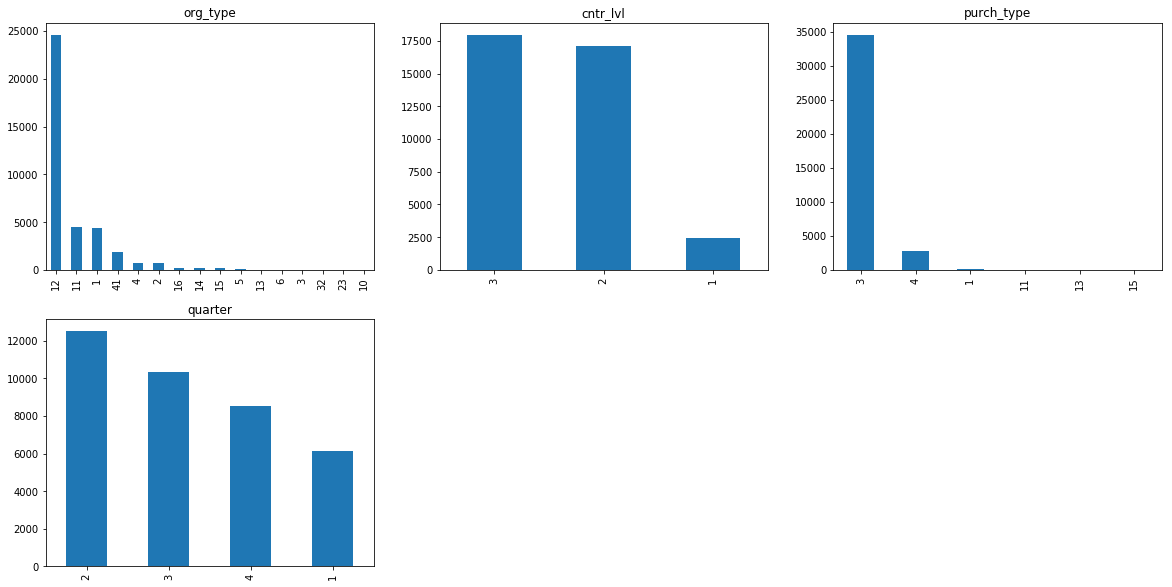

In [50]:
# Частостная гистограмма для переменных с небольшим количеством уникальных значения
fig = plt.figure(figsize=(20, 10))
idx = 1
for cv in cat_var:
    if cv not in ('okpd_2', 'okpd_3', 'okpd_4', 'org_form'):
        ax = fig.add_subplot(2, 3, idx)
        data[cv].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(cv)
        idx += 1

In [51]:
# Группировка значений, встречающихся реже в 0,5% случаев
df = data.copy()
for cv in cat_var:
    cnt = data[cv].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        if count / data.shape[0] <= 0.005:
            data.loc[data[cv] == val, cv] = 'NEW'
    print('{} - было: {}, стало: {} ({:.2f})'.format(
        cv, len(set(df[cv].values)), len(set(data[cv].values)), 
        (len(set(df[cv].values)) - len(set(data[cv].values))) / len(set(df[cv].values))))

org_form - было: 70, стало: 8 (0.89)
org_type - было: 16, стало: 9 (0.44)
cntr_lvl - было: 3, стало: 3 (0.00)
purch_type - было: 6, стало: 3 (0.50)
okpd_2 - было: 75, стало: 21 (0.72)
okpd_3 - было: 192, стало: 30 (0.84)
okpd_4 - было: 349, стало: 38 (0.89)
quarter - было: 4, стало: 4 (0.00)


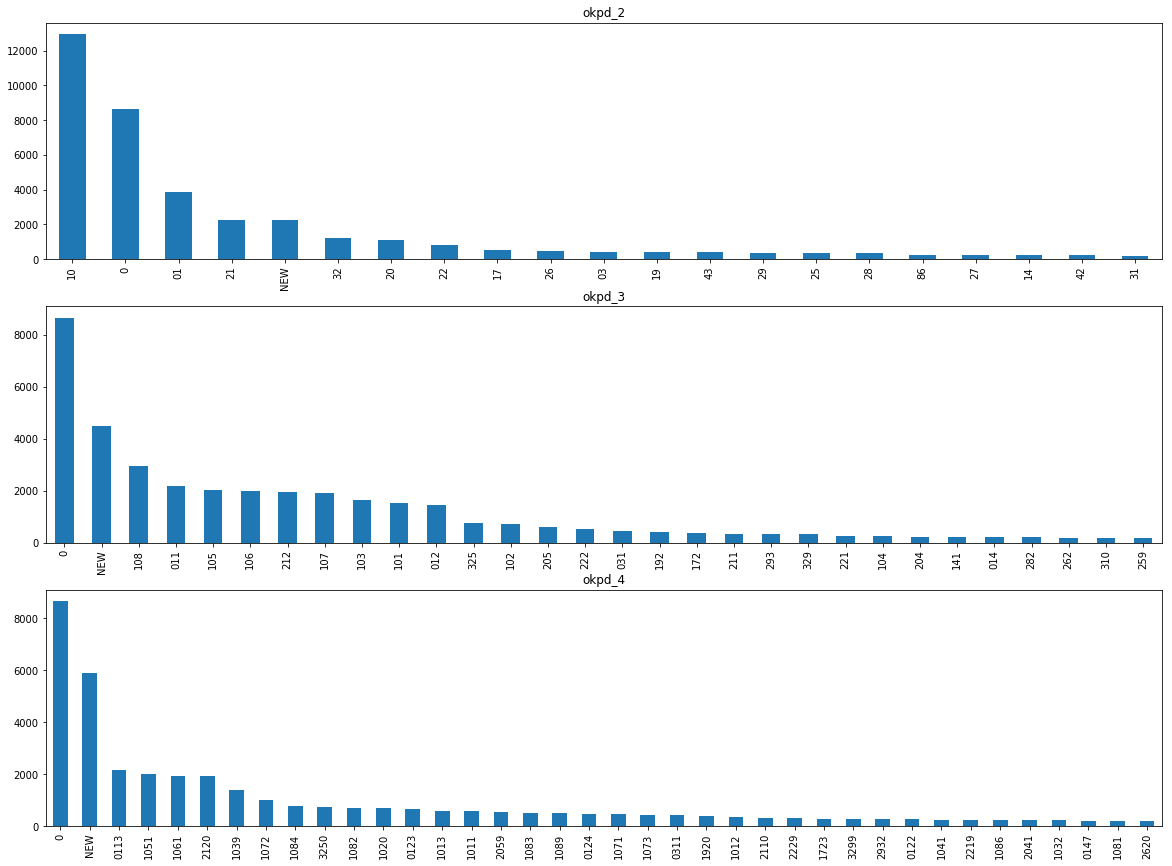

In [52]:
# Частотные гистограммы для переменных с большим количеством уникальных значений
fig = plt.figure(figsize=(20, 20))
for idx, cv in enumerate(('okpd_2', 'okpd_3', 'okpd_4')):
    ax = fig.add_subplot(4, 1, idx + 1)
    data[cv].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(cv)

In [53]:
# WoE кодирование
for cv in cat_var:
    cnt = data[cv].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        good_with_val = data.loc[(data.cntr_result == 1) & (data[cv] == val)].shape[0]
        bad_with_val = data.loc[(data.cntr_result == 0) & (data[cv] == val)].shape[0]
        
        p = good_with_val / data.loc[data.cntr_result == 1].shape[0]
        q = bad_with_val / data.loc[data.cntr_result == 0].shape[0]
        data.loc[data[cv] == val, cv] = round(np.log(p / q), 3)

### Предобработка бинарных переменных

In [54]:
# Удаление переменных
cat_bin_var.clear()

# Обучение моделей

In [55]:
import time
import itertools

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, ParameterGrid

from sklearn.feature_selection import RFECV

from sklearn.calibration import calibration_curve

In [56]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nAccuracy на обучающей выборке: {3:.3f}\n'
        'Accuracy на тестовой выборке: {4:.3f}\n'
        'Log loss на тестовой выборке: {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Хороший', 'Плохой')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """
    Построение соответствия между реальными и предсказываемыми моделью 
    значениями целевой переменной
    """
    
    return pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,1]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )

def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказываемые значения')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0, counter1 = Counter(), Counter()

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Хорошие контракты', 'Плохие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred_proba):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

def learn_one_model(clf, clf_name, X, y, kfold=10, silent=False):
    """Функция для обучения одной модели"""
    
    start_time = time.time()
    
    if silent:
        print('Обучение %s' % clf_name)
    
    # Кросс-валидация 
    kfolds_generator = StratifiedKFold(n_splits=kfold, random_state=RANDOM_SEED)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X, y)):
        if not silent:
            print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        clf.clf.fit(X_train, y_train)
    
        clf.y_train_real = np.concatenate((clf.y_train_real, y_train))
        clf.y_test_real = np.concatenate((clf.y_test_real, y_test))

        clf.y_train_pred = np.concatenate((clf.y_train_pred, clf.clf.predict(X_train)))
        clf.y_test_pred = np.concatenate((clf.y_test_pred, clf.clf.predict(X_test)))
        
        clf.y_train_pred_proba = np.concatenate((clf.y_train_pred_proba, clf.clf.predict_proba(X_train))) 
        clf.y_test_pred_proba = np.concatenate((clf.y_test_pred_proba, clf.clf.predict_proba(X_test))) 
    
    # Соответствие между реальными и предсказываемыми моделью значениями целевой переменной
    clf.res = real_and_predicted_correlation(clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba)
    
    # Время обучения модели
    clf.train_time = int(time.time() - start_time)
    
    if not silent:
        print("Обучение заняло %s секунд\n" % (time.time() - start_time))
        # Общая информация о модели
        print_classifier_info(
            clf_name, clf.y_train_real, clf.y_train_pred, 
            clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba
        )
        
        # Матрица ошибок
        plot_confusion_matrix(
            confusion_matrix(clf.y_test_real, clf.y_test_pred), 
            classes=clf.clf.classes_, 
            title='Матрица ошибок'
        )
        
        # Распределение конрактов
        plot_dependence(clf.res)
        
        # ROC-кривая
        plot_roc_curve(clf.y_test_real, clf.y_test_pred_proba[:,1])

def assess_probability_power(clfs, figsize=(20, 10)):
    """Визуализации вероятностной предсказательной силы классификатора"""
    
    fig = plt.figure(figsize=figsize)
    clf_num = len(clfs)
    res = {}
    
    for idx, clf in enumerate(clfs):
        ax1 = fig.add_subplot(2, clf_num, idx + 1)    
        ax1.plot([0, 1], [0, 1], "k:", label="Идеальный классификатор")
        ax2 = fig.add_subplot(2, clf_num, idx + 1 + clf_num)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            clf.y_test_real, clf.y_test_pred_proba[:,1], n_bins=10)

        ax1.plot(
            mean_predicted_value, fraction_of_positives, "s-", 
            label='%s (log loss: %1.3f)' % (clf.short_name, log_loss(clf.y_test_real, clf.y_test_pred_proba))
        )
        ax2.hist(clf.y_test_pred_proba[:,1], range=(0, 1), bins=10, histtype="step", lw=2)

        ax1.set_ylabel('Доля наблюдений плохого класса')
        ax1.set_xlabel('Средняя предсказываемая вероятность')
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc='lower right')
        ax1.set_title(clf.short_name)

        ax2.set_ylabel('Количество наблюдений')
        ax2.set_xlabel('Средняя предсказываемая вероятность')

In [57]:
# Переменные для включения в модель
var = []
var.extend(num_var)
var.extend(cat_var)
var.extend(num_var01)
var.extend(cat_bin_var)

In [58]:
# Выборка для обучения моделей
sample = data[var + ['cntr_result']]
sample = sample.sample(frac=1, random_state=RANDOM_SEED)
X = sample.drop(['cntr_result'], axis=1).values
y = sample.cntr_result.values

In [59]:
print('Размер выборки: {}'.format(sample.shape))

Размер выборки: (37544, 24)


In [60]:
sample.head()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,cntr_length,org_form,org_type,cntr_lvl,purch_type,okpd_2,okpd_3,okpd_4,quarter,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_sim_price_share,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_nun_cntr_share,okpd_good_cntr_share,cntr_result
36732,1.163147,-0.327834,0.310738,-1.521042,0.222581,0.088,0.099,-0.849,0.053,1.024,0.721,0.722,0.132,0.883,0.000,0.584,0.416,0.10822,1.000,0.0,1.0,0.0,0.947739,0
31699,-0.353699,0.952921,-1.074556,-1.150667,1.385019,0.088,-0.177,-1.199,0.053,1.024,1.083,1.241,0.047,0.808,0.932,0.068,0.000,0.10959,1.000,1.0,0.0,0.0,0.859118,0
30586,0.656692,1.224678,1.204884,0.449462,1.488578,0.088,0.099,-0.849,0.053,-2.524,-2.142,-2.075,0.132,0.990,0.000,1.000,0.000,0.02708,0.932,0.0,1.0,0.0,0.963989,0
40267,1.163147,-0.327834,-0.598156,0.595591,0.201317,0.088,0.099,0.980,0.053,1.024,1.083,0.484,-0.037,0.883,0.000,0.584,0.416,0.10851,0.740,0.0,0.0,1.0,0.971098,0
23459,1.163147,-0.327834,0.019287,-1.290699,0.334717,0.088,0.099,-0.849,0.053,1.024,0.721,0.722,-0.182,0.883,0.000,0.584,0.416,0.09551,0.996,0.0,1.0,0.0,0.931221,0


### Первичные модели

In [61]:
class Classifier():
    """Класс для удобства обучения моделей"""
    
    def __init__(self, clf, name, short_name):
        self.clf = clf
        self.name = name
        self.short_name = short_name
    
    y_train_real = np.array([])
    y_test_real = np.array([])
    
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    
    y_train_pred_proba = np.zeros((0, 2))
    y_test_pred_proba = np.zeros((0, 2))

In [62]:
# Классификаторы
classifiers = [
    Classifier(LogisticRegression(random_state=RANDOM_SEED), 'LogisticRegression', 'LogReg'),
    Classifier(RandomForestClassifier(random_state=RANDOM_SEED), 'RandomForestClassifier', 'RandForest'),
    Classifier(XGBClassifier(random_state=RANDOM_SEED), 'XGBoostClassifier', 'XGBoost'),
]

In [63]:
%%time
# Обучение первичных моделей на кросс-валидации
scores = []
metrics = ['roc_auc', 'accuracy', 'neg_log_loss']
for clf in classifiers:
    scores.append(
        cross_validate(
            clf.clf, X, y, scoring=metrics, 
            cv=10, return_train_score=True
        )
    )

CPU times: user 35.6 s, sys: 759 ms, total: 36.3 s
Wall time: 38.1 s


In [64]:
# Вывод результатов
res = {}
metric_keys = ['train_{}'.format(metric) for metric in metrics]
metric_keys.extend(['test_{}'.format(metric) for metric in metrics])

for clf, score in zip(classifiers, scores):
    res[clf.short_name] = [np.mean(score[metric]) for metric in metric_keys]
    
res = pd.DataFrame(res, index=metric_keys)
res = res.round(decimals=3)
res = res[['LogReg', 'RandForest', 'XGBoost']]
res

,LogReg,RandForest,XGBoost
train_roc_auc,0.928,1.000,0.952
train_accuracy,0.852,0.995,0.881
train_neg_log_loss,-0.347,-0.055,-0.270
test_roc_auc,0.927,0.969,0.950
test_accuracy,0.851,0.917,0.880
test_neg_log_loss,-0.348,-0.452,-0.275


In [65]:
# Обучение моделей с помощью самописной функции
for clf in classifiers:
    learn_one_model(clf, clf.short_name, X, y, silent=True)

Обучение LogReg
Обучение RandForest
Обучение XGBoost


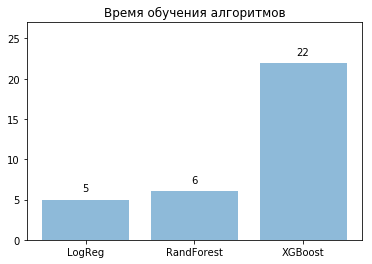

In [66]:
# Время обучения моделей
y_pos = range(3)
train_time = [clf.train_time for clf in classifiers]

plt.bar(y_pos, train_time, alpha=0.5)
plt.xticks(y_pos, [clf.short_name for clf in classifiers])
plt.title('Время обучения алгоритмов')
plt.ylim(0, int(max(train_time)*1.25))

for idx, tt in enumerate(train_time):
    plt.text(idx, tt + 1, str(tt), ha='center')
    
plt.show()

In [67]:
# Анализ важности признаков для алгоритма
log_reg_fi = sorted(
    list(zip(sample.columns[:-1], classifiers[0].clf.coef_[0])),
    key=lambda a: np.abs(a[1]), 
    reverse=True
)

rand_forest_fi = sorted(
    list(zip(sample.columns[:-1], classifiers[1].clf.feature_importances_)),
    key=lambda a: a[1], 
    reverse=True
)

xgboost_fi = sorted(
    list(zip(sample.columns[:-1], classifiers[2].clf.feature_importances_)),
    key=lambda a: a[1],
    reverse=True
)

res = pd.DataFrame(
    {
        'LogReg': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in log_reg_fi],
        'RandForest': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in rand_forest_fi],
        'XGBoost': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in xgboost_fi]
    }, index=range(1, 24))

In [68]:
# 5 самых важных для модели признаков
res.head(5)

,LogReg,RandForest,XGBoost
1,sup_good_cntr_share: -10.64,sup_good_cntr_share: 0.25,sup_good_cntr_share: 0.29
2,org_good_cntr_share: -8.96,org_good_cntr_share: 0.14,org_good_cntr_share: 0.24
3,org_nun_cntr_share: 5.14,okpd_good_cntr_share: 0.07,okpd_good_cntr_share: 0.11
4,sup_fed_cntr_share: 4.08,okpd_3: 0.07,cntr_length: 0.05
5,sup_sub_cntr_share: 3.96,sup_sim_price_share: 0.07,sup_sim_price_share: 0.05


In [69]:
# 5 самых НЕважных для модели признаков
res.iloc[-5:,:]

,LogReg,RandForest,XGBoost
19,org_type: 0.19,org_type: 0.01,okpd_2: 0.00
20,okpd_4: 0.13,org_sub_cntr_share: 0.01,sup_fed_cntr_share: 0.00
21,okpd_3: 0.10,org_form: 0.00,org_form: 0.00
22,org_cntr_num: 0.09,purch_type: 0.00,cntr_lvl: 0.00
23,org_cntr_avg_price: 0.02,org_fed_cntr_share: 0.00,org_fed_cntr_share: 0.00


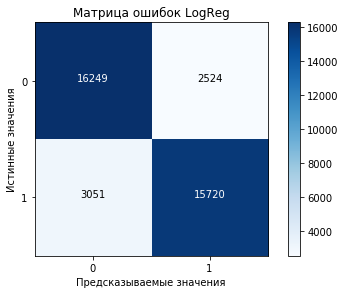

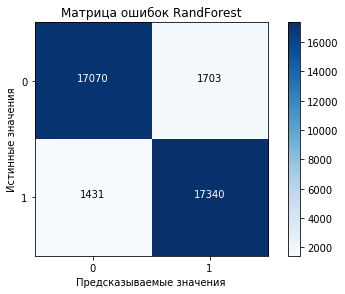

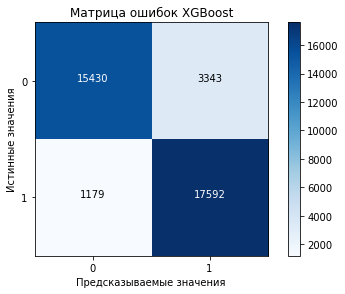

In [70]:
# Матрица ошибок
for clf in classifiers:
    plot_confusion_matrix(
        confusion_matrix(clf.y_test_real, clf.y_test_pred),
        clf.clf.classes_,
        title='Матрица ошибок %s' % clf.short_name
    )

In [71]:
# Основные метрики
for clf in classifiers:
    print('{}\n{}\n'.format(
        clf.short_name,
        classification_report(clf.y_test_real, clf.y_test_pred, target_names=('Хороший', 'Плохой'))))

LogReg
             precision    recall  f1-score   support

    Хороший       0.84      0.87      0.85     18773
     Плохой       0.86      0.84      0.85     18771

avg / total       0.85      0.85      0.85     37544


RandForest
             precision    recall  f1-score   support

    Хороший       0.92      0.91      0.92     18773
     Плохой       0.91      0.92      0.92     18771

avg / total       0.92      0.92      0.92     37544


XGBoost
             precision    recall  f1-score   support

    Хороший       0.93      0.82      0.87     18773
     Плохой       0.84      0.94      0.89     18771

avg / total       0.88      0.88      0.88     37544




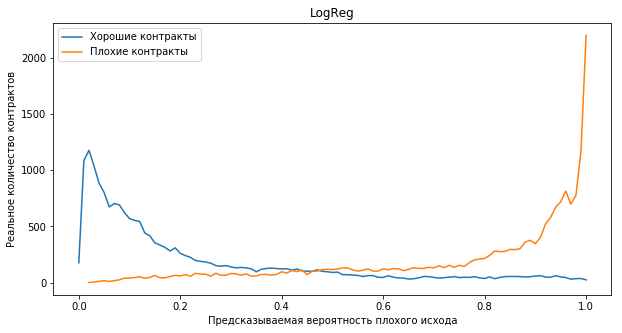

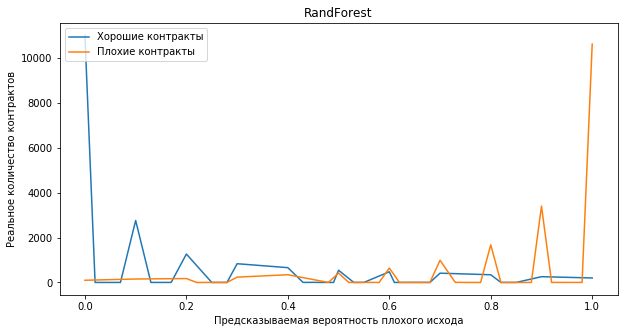

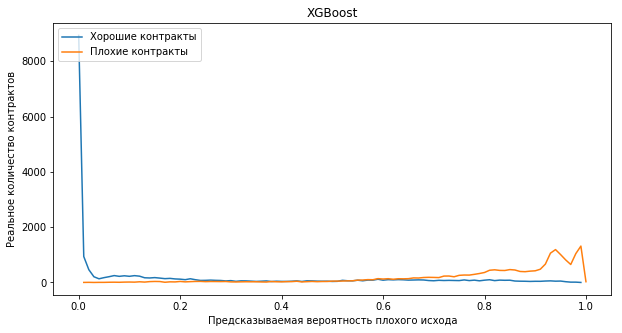

In [72]:
# Вероятностное предсказательное качество модели
# Распределение контрактов по предсказываемой вероятности отнесения наблюдения к плохому классу
for clf in classifiers:
    plot_dependence(clf.res, title=clf.short_name)

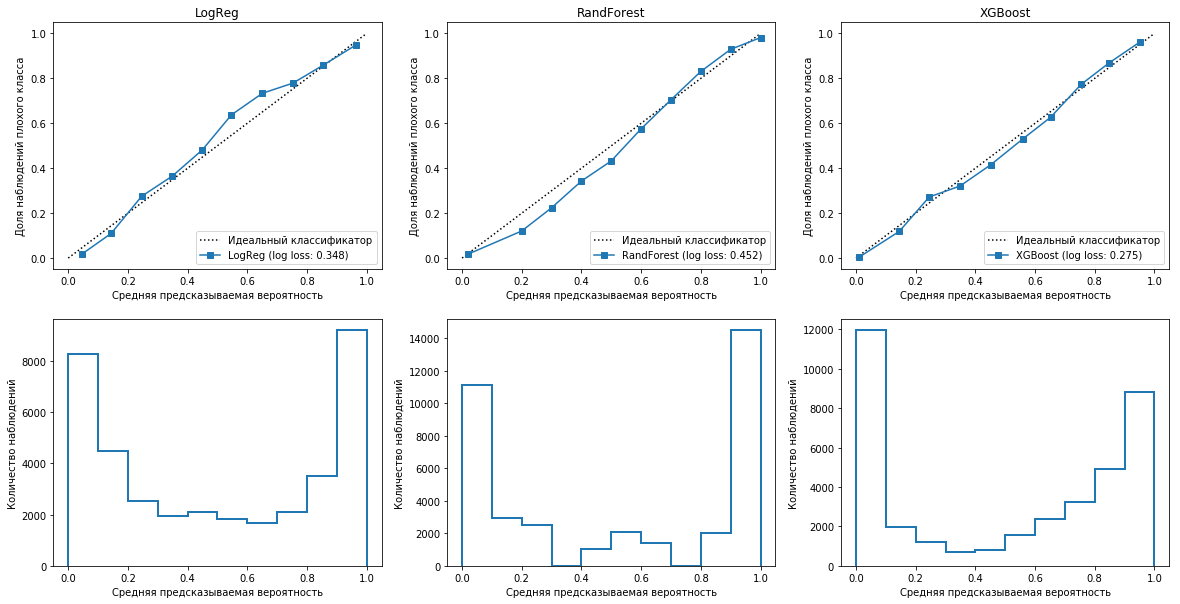

In [73]:
# Альтернативный способ визуализации вероятностного предсказательного качества классификаторов
assess_probability_power(classifiers)

### Подбор параметров

Подбор параметров был произведен в соседнем кодбуке, а результаты записаны в файл parameter_tuning.csv. Здесь используются результаты.

In [74]:
# Считывание результатов
result = pd.read_csv('parameter_tuning.csv')

In [75]:
# Форматирование
result.insert(0, 'algorithm', result['Unnamed: 0'].apply(lambda a: pd.Series(a.split()[0].strip())))
result.insert(1, 'params', result['Unnamed: 0'].apply(lambda a: pd.Series(a.split()[1].strip())))
result.loc[result.algorithm=='LogRer', 'algorithm'] = 'LogReg'
result.drop(['Unnamed: 0'], inplace=True, axis=1)
result = result.round(3)

In [76]:
# 5 случайных строк
result.sample(5, random_state=RANDOM_SEED)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
219,XGBoost,0.3_Silent_8_100_42_1,0.932,0.932,0.174,0.901,0.901,0.232,0.903,0.903,0.234,43.0
66,XGBoost,0.03_Silent_3_1000_42_1,0.928,0.927,0.182,0.901,0.901,0.235,0.899,0.900,0.242,172.0
9,LogReg,0.1_l1_42_saga,0.852,0.852,0.347,0.852,0.852,0.347,0.852,0.852,0.348,9.0
170,XGBoost,0.1_Silent_8_1000_42_0.85,1.000,1.000,0.013,0.919,0.919,0.240,0.918,0.918,0.246,480.0
15,LogReg,1_l2_42_saga,0.852,0.852,0.346,0.852,0.852,0.347,0.852,0.852,0.348,13.0


In [77]:
print('Подбор параметров занял {:.2f}'.format(sum(result.time) / 3600))
print('Подбор параметров для LogReg занял {:.2f}'.format(sum(result.loc[result.algorithm=='LogReg'].time) / 3600))
print('Подбор параметров для RandForest занял {:.2f}'.format(sum(result.loc[result.algorithm=='RandForest'].time) / 3600))
print('Подбор параметров для XGBoost занял {:.2f}'.format(sum(result.loc[result.algorithm=='XGBoost'].time) / 3600))

Подбор параметров занял 8.90
Подбор параметров для LogReg занял 0.18
Подбор параметров для RandForest занял 0.64
Подбор параметров для XGBoost занял 8.08


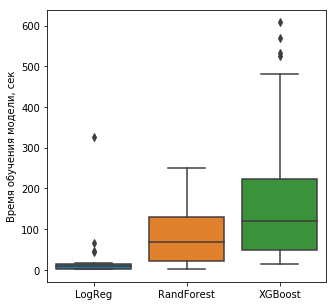

In [78]:
# Время обучения моделей для различных алгоритмов
ax = plt.figure(figsize=(5,5)).gca()
ax = sbs.boxplot(x=result.algorithm, y=result.time, ax=ax)
ax.set(ylabel='Время обучения модели, сек', xlabel='')
plt.show()

In [79]:
# Топ 5 лучших логистических регрессий
result.loc[result.algorithm=='LogReg'].sort_values(by='valid_ll').head(5)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
23,LogReg,100_l2_42_saga,0.853,0.853,0.346,0.853,0.853,0.347,0.853,0.853,0.348,12.0
21,LogReg,100_l1_42_saga,0.853,0.853,0.346,0.853,0.853,0.347,0.853,0.853,0.348,15.0
20,LogReg,100_l1_42_liblinear,0.853,0.853,0.346,0.853,0.853,0.347,0.853,0.853,0.348,46.0
19,LogReg,10_l2_42_saga,0.853,0.853,0.346,0.853,0.853,0.347,0.853,0.853,0.348,18.0
18,LogReg,10_l2_42_liblinear,0.853,0.853,0.346,0.853,0.853,0.347,0.853,0.853,0.348,7.0


In [80]:
# Топ 5 лучших случайных лесов
result.loc[result.algorithm=='RandForest'].sort_values(by='valid_ll').head(5)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
49,RandForest,8_600_42,0.891,0.891,0.286,0.882,0.882,0.301,0.883,0.884,0.301,153.0
47,RandForest,8_200_42,0.890,0.890,0.286,0.882,0.882,0.301,0.884,0.884,0.301,49.0
51,RandForest,8_1000_42,0.891,0.890,0.286,0.882,0.882,0.301,0.883,0.883,0.302,249.0
48,RandForest,8_400_42,0.891,0.891,0.286,0.882,0.882,0.302,0.883,0.884,0.302,100.0
50,RandForest,8_800_42,0.891,0.891,0.286,0.882,0.882,0.301,0.883,0.884,0.302,192.0


In [81]:
# Топ 5 лучших градиентных бустингов
result.loc[result.algorithm=='XGBoost'].sort_values(by='valid_ll').head(5)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
104,XGBoost,0.03_Silent_8_400_42_0.85,0.995,0.995,0.049,0.918,0.918,0.209,0.915,0.916,0.214,204.0
164,XGBoost,0.1_Silent_8_400_42_0.85,0.995,0.995,0.049,0.918,0.918,0.209,0.915,0.916,0.214,207.0
224,XGBoost,0.3_Silent_8_400_42_0.85,0.995,0.995,0.049,0.918,0.918,0.209,0.915,0.916,0.214,189.0
100,XGBoost,0.03_Silent_8_200_42_0.7,0.973,0.973,0.100,0.913,0.913,0.212,0.909,0.910,0.215,110.0
101,XGBoost,0.03_Silent_8_200_42_0.85,0.972,0.972,0.103,0.913,0.913,0.211,0.910,0.911,0.215,105.0


In [82]:
# Валидационная выборка, используемая для тестирования модели после подбора параметров
threshold = int(data.shape[0] * 0.2)
valid_sample = sample.iloc[:threshold,:]
valid_X = valid_sample.drop(['cntr_result'], axis=1).values
valid_y = valid_sample.cntr_result.values

# Тренировочная выборка для подбора параметров
train_test_sample = sample.iloc[threshold:,:]
train_test_X = train_test_sample.drop(['cntr_result'], axis=1).values
train_test_y = train_test_sample.cntr_result.values

In [83]:
# Модели с оптимальными параметрами
tuned_classifiers = [
    Classifier(
        RandomForestClassifier(random_state=RANDOM_SEED, max_depth=8, n_estimators=200), 
        'RandomForestClassifier', 'T_RandForest'),
    Classifier(
        XGBClassifier(random_state=RANDOM_SEED, eta=0.03, max_depth=8, n_estimators=400, subsample=0.85), 
        'XGBoostClassifier', 'T_XGBoost')
]

In [84]:
%%time
# Обучение моделей и добавление данных по валидационной выборке
for t_clf in tuned_classifiers:
    learn_one_model(t_clf, t_clf.short_name, train_test_X, train_test_y, silent=True)
    
    t_clf.y_valid = valid_y
    t_clf.y_valid_pred = t_clf.clf.predict(valid_X)
    t_clf.y_valid_pred_proba = t_clf.clf.predict_proba(valid_X)
    
    t_clf.res_valid = pd.DataFrame({'result': t_clf.y_valid}).join(
        pd.DataFrame({'proba_pred':t_clf.y_valid_pred_proba[:,1]}).join(
            pd.DataFrame({'pred': t_clf.y_valid_pred})))

Обучение T_RandForest
Обучение T_XGBoost
CPU times: user 4min 16s, sys: 2.09 s, total: 4min 18s
Wall time: 4min 29s


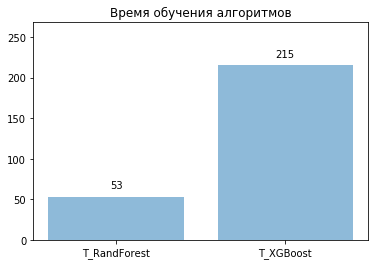

In [85]:
# Время обучения моделей
y_pos = range(2)
train_time = [clf.train_time for clf in tuned_classifiers]

plt.bar(y_pos, train_time, alpha=0.5)
plt.xticks(y_pos, [clf.short_name for clf in tuned_classifiers])
plt.title('Время обучения алгоритмов')
plt.ylim(0, int(max(train_time)*1.25))

for idx, tt in enumerate(train_time):
    plt.text(idx, tt + max(train_time) * 0.05, str(tt), ha='center')
    
plt.show()

In [86]:
# Анализ важности признаков для алгоритма
t_rand_forest_fi = sorted(
    list(zip(sample.columns[:-1], tuned_classifiers[0].clf.feature_importances_)),
    key=lambda a: a[1], 
    reverse=True
)

t_xgboost_fi = sorted(
    list(zip(sample.columns[:-1], classifiers[1].clf.feature_importances_)),
    key=lambda a: a[1],
    reverse=True
)

t_res = pd.DataFrame(
    {
        'T_RandForest': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in t_rand_forest_fi],
        'T_XGBoost': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in t_xgboost_fi]
    }, index=range(1, 24))

In [87]:
# 5 самых важных переменных
t_res.head(5)

,T_RandForest,T_XGBoost
1,sup_good_cntr_share: 0.34,sup_good_cntr_share: 0.25
2,org_good_cntr_share: 0.21,org_good_cntr_share: 0.14
3,okpd_good_cntr_share: 0.07,okpd_good_cntr_share: 0.07
4,okpd_3: 0.06,okpd_3: 0.07
5,okpd_2: 0.06,sup_sim_price_share: 0.07


In [88]:
# 5 самых неважных переменных
t_res.iloc[-5:,:]

,T_RandForest,T_XGBoost
19,org_type: 0.00,org_type: 0.01
20,sup_fed_cntr_share: 0.00,org_sub_cntr_share: 0.01
21,org_form: 0.00,org_form: 0.00
22,purch_type: 0.00,purch_type: 0.00
23,org_fed_cntr_share: 0.00,org_fed_cntr_share: 0.00


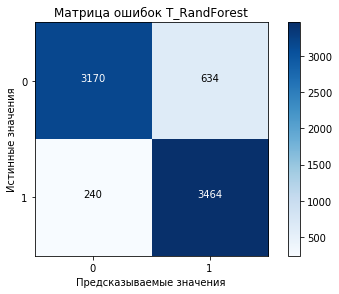

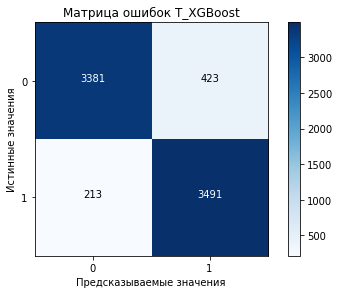

In [89]:
# Матрица ошибок
for t_clf in tuned_classifiers:
    plot_confusion_matrix(
        confusion_matrix(t_clf.y_valid, t_clf.y_valid_pred),
        t_clf.clf.classes_,
        title='Матрица ошибок %s' % t_clf.short_name
    )

In [90]:
# Основные метрики
for t_clf in tuned_classifiers:
    print('{}\n{}\n'.format(
        t_clf.short_name,
        classification_report(t_clf.y_valid, t_clf.y_valid_pred, target_names=('Хороший', 'Плохой'))))

T_RandForest
             precision    recall  f1-score   support

    Хороший       0.93      0.83      0.88      3804
     Плохой       0.85      0.94      0.89      3704

avg / total       0.89      0.88      0.88      7508


T_XGBoost
             precision    recall  f1-score   support

    Хороший       0.94      0.89      0.91      3804
     Плохой       0.89      0.94      0.92      3704

avg / total       0.92      0.92      0.92      7508




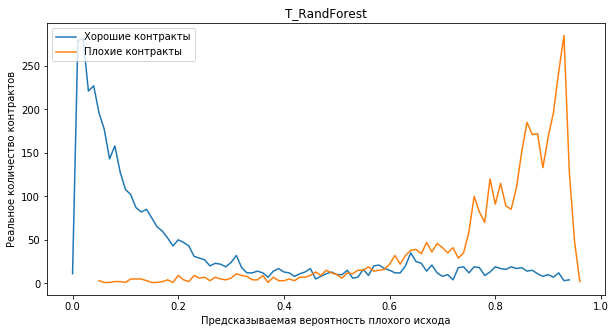

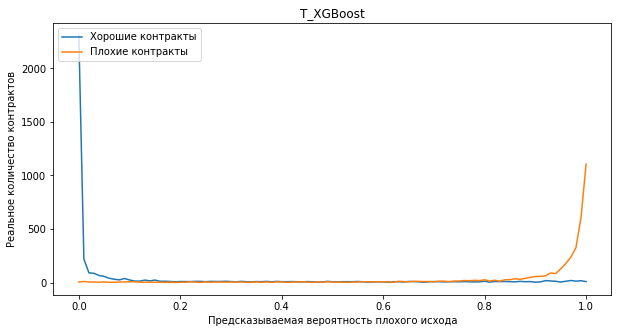

In [91]:
# Распределение контрактов
for t_clf in tuned_classifiers:
    plot_dependence(t_clf.res_valid, title=t_clf.short_name)

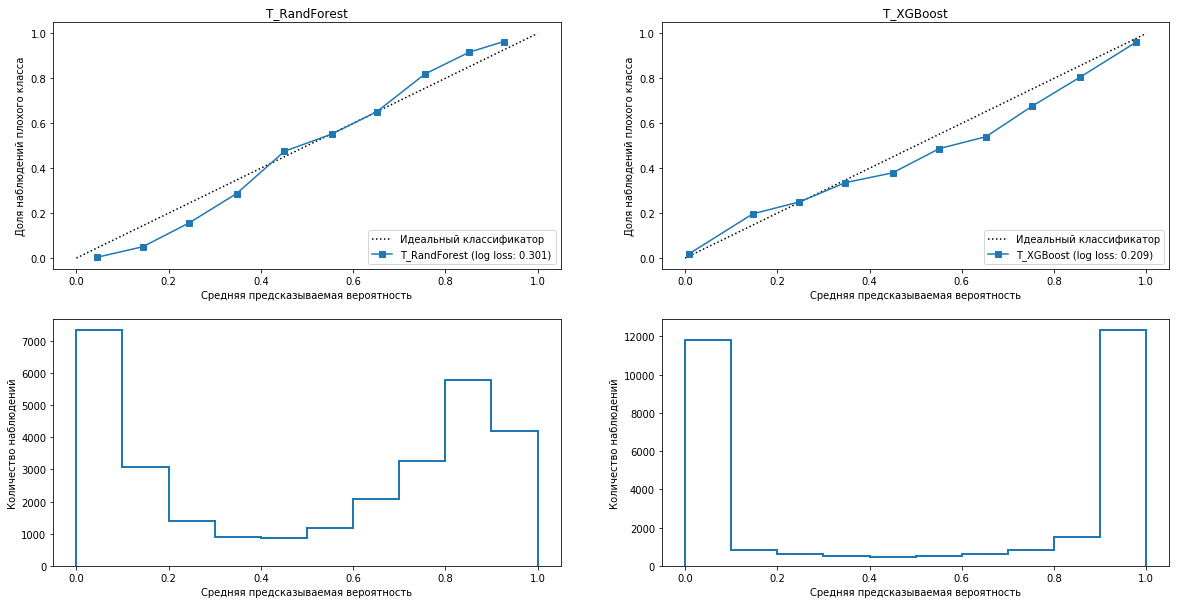

In [92]:
# Альтернативный способ визуализации вероятностного предсказательного качества классификаторов
assess_probability_power(tuned_classifiers)

### Отбор признаков

In [93]:
rfe_classifiers = [
    Classifier(LogisticRegression(random_state=RANDOM_SEED), 'LogisticRegression', 'RFE_LogReg'),
    Classifier(
        RandomForestClassifier(random_state=RANDOM_SEED, max_depth=8, n_estimators=200), 
        'RandomForestClassifier', 'RFE_T_RandForest'),
    Classifier(
        XGBClassifier(random_state=RANDOM_SEED, eta=0.03, max_depth=8, n_estimators=400, subsample=0.85), 
        'XGBoostClassifier', 'RFE_T_XGBoost')
]

RFE для RFE_LogReg
42 сек: sup_cntr_num, sup_cntr_avg_price, org_cntr_num, cntr_length, org_form, org_type, cntr_lvl, purch_type, okpd_2, okpd_3, okpd_4, quarter, sup_good_cntr_share, sup_fed_cntr_share, sup_sub_cntr_share, sup_nun_cntr_share, sup_sim_price_share, org_good_cntr_share, org_fed_cntr_share, org_sub_cntr_share, org_nun_cntr_share, okpd_good_cntr_share

RFE для RFE_T_RandForest
964 сек: okpd_2, sup_good_cntr_share, org_good_cntr_share, okpd_good_cntr_share

RFE для RFE_T_XGBoost
3353 сек: sup_cntr_num, sup_cntr_avg_price, org_cntr_num, org_cntr_avg_price, cntr_length, okpd_2, okpd_3, okpd_4, quarter, sup_good_cntr_share, sup_fed_cntr_share, sup_sub_cntr_share, sup_sim_price_share, org_good_cntr_share, okpd_good_cntr_share

CPU times: user 1h 11min 53s, sys: 13.3 s, total: 1h 12min 7s
Wall time: 1h 12min 39s


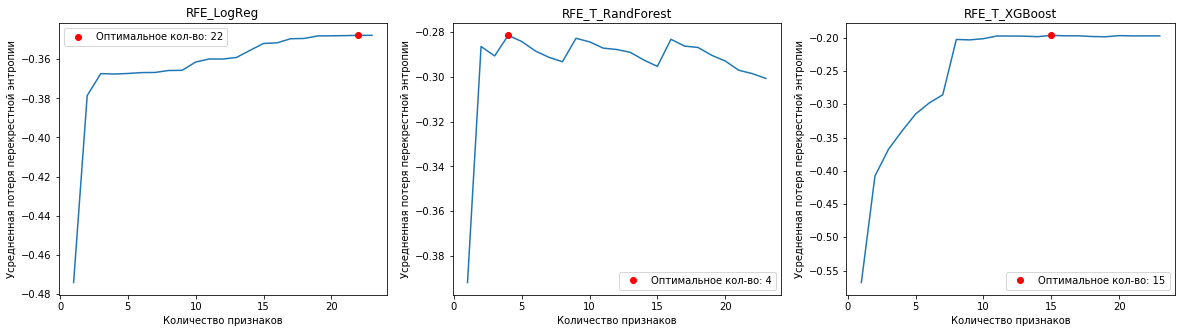

In [94]:
%%time
# Отбор признаков
fig = plt.figure(figsize=(20, 5))
rfecvs = []
for idx, clf in enumerate(rfe_classifiers):
    start_time = time.time()
    
    print('RFE для %s' % clf.short_name)
    rfecv = RFECV(
        clf.clf, step=1, cv=StratifiedKFold(n_splits=10, random_state=RANDOM_SEED), 
        scoring='neg_log_loss')
    rfecv.fit(X, y)
    rfecvs.append(rfecv)
    
    ax = fig.add_subplot(1, 3, idx + 1)
    ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    ax.plot(rfecv.n_features_, max(rfecv.grid_scores_), 'ro', label='Оптимальное кол-во: {}'.format(rfecv.n_features_))
    ax.set_title(clf.short_name)
    ax.set_xlabel("Количество признаков")
    ax.set_ylabel("Усредненная потеря перекрестной энтропии")
    ax.legend()
    
    best_set_of_features = [
        column for (score, column) in zip(list(rfecv.support_), list(sample.columns)) if score
    ]

    print("{} сек: {}\n".format(
        int(time.time() - start_time), 
        ', '.join(best_set_of_features)
    ))

In [95]:
# Переменные в порядке убывания важности для алгоритма
rfe_log_reg_fi = sorted(
    list(zip(sample.columns[:-1], classifiers[0].clf.coef_[0])),
    key=lambda a: np.abs(a[1]), 
    reverse=True
)

rfe_t_rand_forest_fi = sorted(
    list(zip(sample.columns[:-1], tuned_classifiers[0].clf.feature_importances_)),
    key=lambda a: a[1], 
    reverse=True
)

rfe_t_xgboost_fi = sorted(
    list(zip(sample.columns[:-1], tuned_classifiers[1].clf.feature_importances_)),
    key=lambda a: a[1],
    reverse=True
)

In [96]:
# Выбор отобранных переменных для каждого алгортитма
log_reg_vars = [column for column, value in rfe_log_reg_fi[:22]]
rfe_t_rand_forest_fi = [column for column, value in rfe_t_rand_forest_fi[:4]]
rfe_t_xgboost_fi = [column for column, value in rfe_t_xgboost_fi[:10]]

In [97]:
%%time
# Обучение моделей на выбранных переменных
for idx, clf in enumerate(rfe_classifiers):
    if idx == 0:
        # Обучение логистической регресси
        X = sample[log_reg_vars].values
        learn_one_model(clf, clf.short_name, X, y, silent=True)
    elif idx == 1:
        # Обучение случайного леса
        X = sample[rfe_t_rand_forest_fi].values
        learn_one_model(clf, clf.short_name, X, y, silent=True)
    else:
        # Обучение градиентного бустинга
        X = sample[rfe_t_xgboost_fi].values
        learn_one_model(clf, clf.short_name, X, y, silent=True)

Обучение RFE_LogReg
Обучение RFE_T_RandForest
Обучение RFE_T_XGBoost
CPU times: user 3min 19s, sys: 709 ms, total: 3min 19s
Wall time: 3min 20s


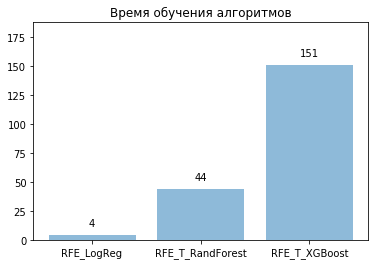

In [98]:
# Время обучения моделей
y_pos = range(3)
train_time = [clf.train_time for clf in rfe_classifiers]

plt.bar(y_pos, train_time, alpha=0.5)
plt.xticks(y_pos, [clf.short_name for clf in rfe_classifiers])
plt.title('Время обучения алгоритмов')
plt.ylim(0, int(max(train_time)*1.25))

for idx, tt in enumerate(train_time):
    plt.text(idx, tt + max(train_time) * 0.05, str(tt), ha='center')
    
plt.show()

In [99]:
# Основные метрики
for clf in rfe_classifiers:
    print('{}\n{}\n'.format(
        clf.short_name,
        classification_report(clf.y_test_real, clf.y_test_pred, target_names=('Хороший', 'Плохой'))))

RFE_LogReg
             precision    recall  f1-score   support

    Хороший       0.84      0.87      0.85     18773
     Плохой       0.86      0.84      0.85     18771

avg / total       0.85      0.85      0.85     37544


RFE_T_RandForest
             precision    recall  f1-score   support

    Хороший       0.93      0.81      0.87     18773
     Плохой       0.83      0.94      0.89     18771

avg / total       0.88      0.88      0.88     37544


RFE_T_XGBoost
             precision    recall  f1-score   support

    Хороший       0.94      0.90      0.92     18773
     Плохой       0.90      0.94      0.92     18771

avg / total       0.92      0.92      0.92     37544




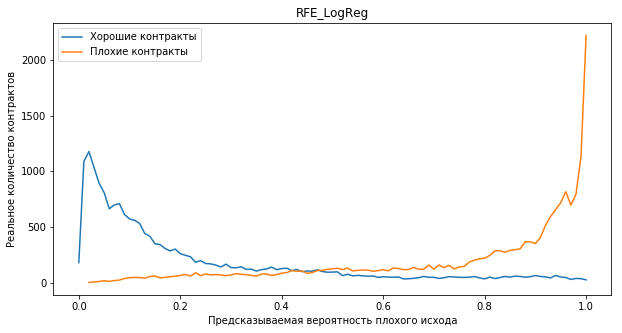

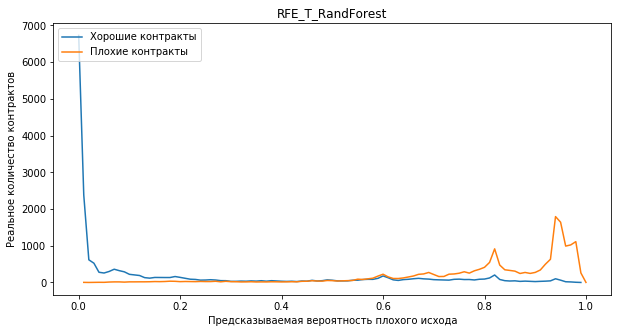

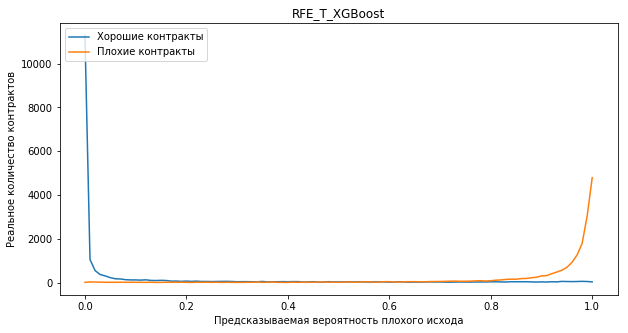

In [100]:
# Распределение контрактов
for clf in rfe_classifiers:
    plot_dependence(clf.res, title=clf.short_name)

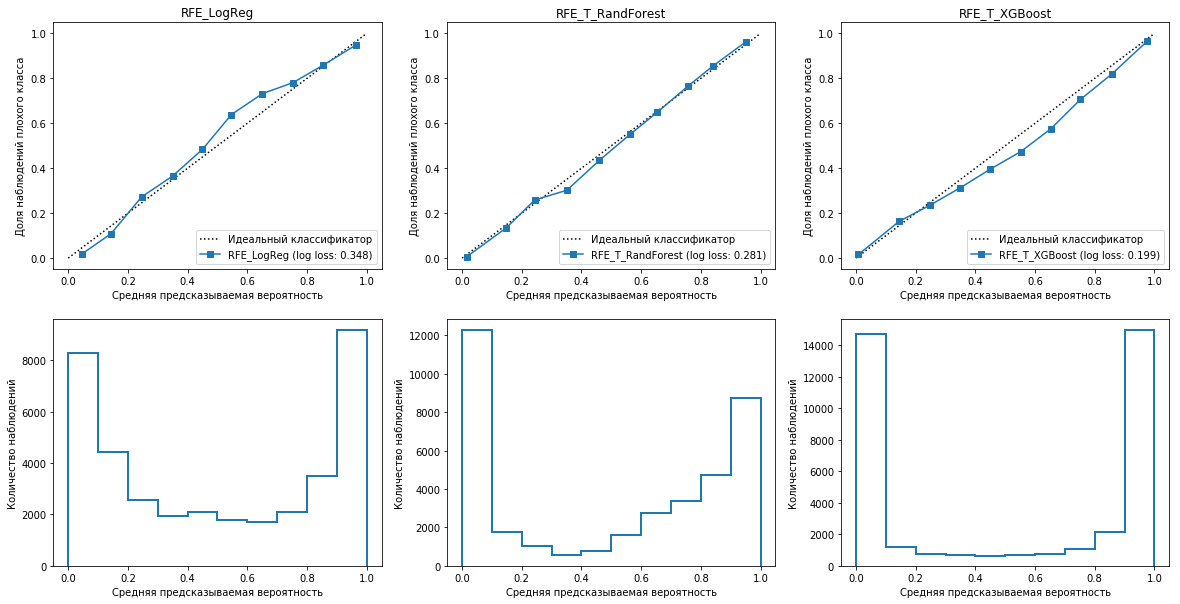

In [101]:
# Альтернативный способ визуализации вероятностного предсказательного качества классификаторов
assess_probability_power(rfe_classifiers)